In [1]:
import numpy as np

In [2]:
A = np.array([
  [0.1817, 0.5394, -0.1197, 0.6404],
  [0.6198   ,0.1994,  0.0946, -0.3121],
  [-0.7634,  -0.8181,  0.9883  ,0.7018]]
)

b = np.array([1.1862, -0.1158,  -0.1093])

In [3]:
x = np.eye(4)

# Matching pursuits

In [1]:
# %load pursuit.py
import numpy as np


def pursuit(A, b, n_steps, pursuit_type='omp', wmp_t=None):
    def get_next_approximation_mp(**kwargs):
        a = kwargs['a_next']
        best_column_index = kwargs['best_column_index']
        x_approx = kwargs['x_approx']
        x_approx[best_column_index] += a * np.linalg.norm(res)
        return x_approx

    def get_next_approximation_omp(**kwargs):
        support = kwargs['support']
        x = np.zeros(A.shape[1])
        x_star = np.linalg.lstsq(A[:, support], b)[0]
        x[support] = x_star
        return x
    
    def get_best_column_wmp(inner_products, wmp_t):
        assert wmp_t is not None
        for i, p in enumerate(inner_products):
            residual_error_norm = np.linalg.norm(res)
            if p >= wmp_t * residual_error_norm:
                return i
        return i
    
    res = b
    support = []
    x_approx = np.zeros(A.shape[1])
    
    get_best_column = np.argmax
    if pursuit_type == 'omp':
        get_next_approximation = get_next_approximation_omp
    elif pursuit_type == 'mp':
        get_next_approximation = get_next_approximation_mp
    elif pursuit_type == 'wmp':
        get_next_approximation = get_next_approximation_mp
        get_best_column = lambda products: get_best_column_wmp(products, wmp_t)

    for __ in range(n_steps):
        inner_products = A.T @ res
        best_column_index = get_best_column(inner_products)
        a_next = inner_products[best_column_index]
        #inner_products[best_column_index] = 0
        best_column = A[:, best_column_index]
        support.append(best_column_index)
        x_approx = get_next_approximation(
            a_next=a_next,
            best_column_index=best_column_index,
            support=support,
            x_approx=x_approx)
        res = b - A @ x_approx

    return support, res, x_approx

In [73]:
support, res, x_approx = pursuit(A, b, 2, pursuit_type='mp')

In [74]:
support, res, x_approx = pursuit(A, b, 2, pursuit_type='wmp', wmp_t=0.5)

In [76]:
A.T @ b

array([ 0.22719932,  0.70616409, -0.26096401,  0.71907692])

In [75]:
support

[1, 3]

In [6]:
np.linalg.norm(b - A @ x_approx)

0.9567531400438529

## LARS 

In [7]:
from sklearn.linear_model import LassoLarsCV, LassoLars, lars_path

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
llars = LassoLars()

In [16]:
beta = np.zeros(100)
beta[0:10] = 25

noise = np.random.randn(20) / 40 
x = np.random.randn(20, 100)

In [17]:
y = x @ beta + noise

In [18]:
llars.fit(x, y)

LassoLars(alpha=1.0, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)

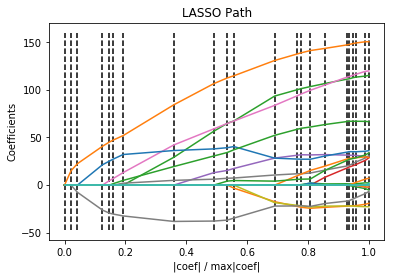

In [19]:
alphas = llars.alphas_
coefs = llars.coef_path_

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyles='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [20]:
llars.active_

[1, 10, 6, 22, 27, 2, 4, 92, 31, 38, 41, 62, 3, 12, 81, 34, 91, 79]

## 3.11 Mathematical introduction to compressive sensing

In [335]:
m = 1000 
N = 10000

random_rademacher = 2 * (np.random.binomial(n=1, p=0.5, size=(m, N)) - 0.5)
A = 1 / np.sqrt(m) * random_rademacher 

In [336]:
n_nonzero = int(np.sqrt(m))

idxs = np.random.choice(np.arange(m), size=10)
x0 = np.zeros(N)
x0[idxs] = 1 / np.sqrt(m)

b0 = A @ x0

In [337]:
%time support, res, x_approx = pursuit(A, b0, n_nonzero)

CPU times: user 1.08 s, sys: 476 ms, total: 1.56 s
Wall time: 518 ms


In [338]:
# correct rate
len([i for i in support if i in idxs]) / n_nonzero

1.0

In [339]:
A_normalized = A / np.linalg.norm(A, axis=0)
G = A_normalized.T @ A_normalized
np.fill_diagonal(G, 0)
mu = G.max()

In [340]:
print(mu)
print(1 + 1/mu)

0.17
6.88235294118


In [341]:
np.sqrt(m)

31.622776601683793

In [342]:
np.linalg.matrix_rank(A)

1000